In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict

In [2]:
%matplotlib inline

In [3]:
url = "https://raw.githubusercontent.com/anoushavan/Capstone_1/master/data/new_buildings.csv"

data = pd.read_csv(url, parse_dates=['Fully Paid','Approved','SIGNOFF_DATE'])

/Users/anushavan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118461 entries, 0 to 118460
Data columns (total 21 columns):
Borough                          118461 non-null object
Building Type                    118461 non-null object
eFiling Filed                    49594 non-null object
Applicant Professional Title     118456 non-null object
Professional Cert                84910 non-null object
Fully Paid                       117514 non-null datetime64[ns]
Approved                         70616 non-null datetime64[ns]
Total Est. Fee                   118461 non-null object
Proposed Zoning Sqft             118461 non-null int64
Proposed No. of Stories          118461 non-null int64
Proposed Height                  118461 non-null int64
Proposed Dwelling Units          68282 non-null object
Proposed Occupancy               79917 non-null object
Zoning Dist1                     79917 non-null object
Zoning Dist2                     6244 non-null object
Zoning Dist3                     247 non-nul

### Clean up the dataframe

* converting all column names to *title case*, <br> 
* converting numeric data into numeric form by removing dollar signs and converting to intiger, <br> 
* creating a **"Duration"** column measuring the duration of the approval process as the difference between the "Approved" and "Fully Paid" columns <br> 
* creating subsets of data to hold normal values, values that are below 0 (meaningless) and zero values.
* Transform "Boroughs" into category to increase the speed of execution.

In [5]:
# Convert all data columns to Title Case
data.columns = data.columns.str.title()

# Convert Total Est. Fee to float data and remove $ symbol 
data['Total Est. Fee']= [float(c.replace('$','')) for c in data['Total Est. Fee']]

In [6]:
# Convert Proposed Dwelling Units to integers
data['Proposed Dwelling Units'] = (pd.to_numeric(data
                                  ['Proposed Dwelling Units'], errors='coerce'))


In [7]:
# Create a Duration column and convert it to integers (instead of days)
data['Duration'] = (data['Approved'] - data['Fully Paid']).dt.days

In [8]:
# Subset of data where the Duration is more than 0 days
data = data[data['Duration'] > 0]

# Subset of data where the Duration is less then 0 days
odd_data = data[data['Duration'] < 0]

# Subset of data where the Duration is 0 days
zero_data = data[data['Duration'] == 0]

In [9]:
# transform the Boroughs into categories for faster analysis.
data['Borough'] = data['Borough'].astype('category')

#### Dealing with blank (NaN/NaT) values

converting the NaN values to N string indicating No.

In [10]:
# Column Efiling Filed: replace the NaN values with N (No)
data['Efiling Filed'] = data['Efiling Filed'].fillna('N')

In [11]:
data['Professional Cert'] = data['Professional Cert'].fillna('N')

##### Potential columns to drop
The column "Proposed Dwelling Units" has 50392 not null values.

The columnn "Fully Permitted" has 7070 NaT entries.


##### Drop rows
There are 2 rows in the "Applicant Professional Title" column that are blank. Assigned them
to del_rows variable and deleted. 

There are also 2 rows in the Processional Cert column that are not Y or N, they should be dropped.

In [12]:
del_rows = data[data['Applicant Professional Title'].isnull()].index
data.drop(del_rows, inplace=True)
data = (data.drop(data[(data['Professional Cert'] == 'J') | 
                            (data['Professional Cert'] == 'R')].index))

### Analysis of data

Creating:
1. histograms (for categorical variables)
2. bar charts (for continuous variables) and 
3. boxplots for categorical variables (x axis) and a continuous variable (y axis).


In [13]:
data.head(2)

,Borough,Building Type,Efiling Filed,Applicant Professional Title,Professional Cert,Fully Paid,Approved,Total Est. Fee,Proposed Zoning Sqft,Proposed No. Of Stories,...,Proposed Occupancy,Zoning Dist1,Zoning Dist2,Zoning Dist3,Special District 1,Special District 2,Non-Profit,Total_Construction_Floor_Area,Signoff_Date,Duration
0,QUEENS,1-2-3 FAMILY,Y,RA,N,2018-11-02,2019-04-09,243.00,2700,2,...,R-3,R3A,NaN,NaN,NaN,NaN,N,4050,NaT,158.0
1,BROOKLYN,OTHERS,Y,RA,N,2012-03-27,2013-03-14,52167.26,161567,14,...,R-1,M1-2/R6,NaN,NaN,MX-8,GW,N,198951,NaT,352.0


In [14]:
# Histogram and the distribution function of Duration.

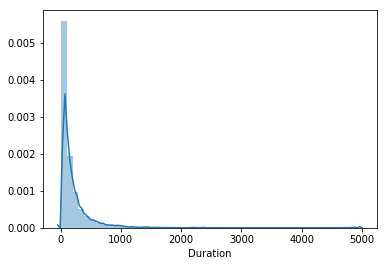

In [15]:
sns.distplot(data['Duration'],bins=50, kde=True);

##### Distribution
* The distribution of the duration has a strong right skew.

,Borough
MANHATTAN,2224
BRONX,7417
STATEN ISLAND,11359
BROOKLYN,17062
QUEENS,21014


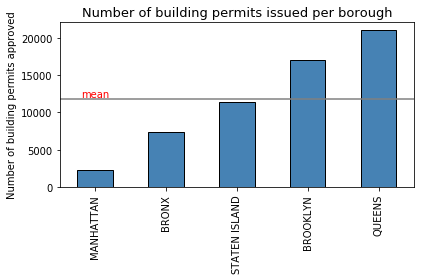

In [16]:
# create a bar plot for the # of building permits issued by Borough
fig, ax = plt.subplots(figsize=(6,4))
average = (data.count()/5)['Borough']
ax = data['Borough'].value_counts().sort_values().plot(kind='bar', 
     color='steelblue', edgecolor='k')
data.groupby(['Borough']).count()
ax.set_ylabel('Number of building permits approved')
ax.set_xlabel('')
plt.axhline(y=average, c='grey')
plt.annotate('mean', xy=(1, 10000), xytext=(-0.2, 12000), color='r')
plt.title('Number of building permits issued per borough', fontsize=13)

plt.tight_layout()
pd.DataFrame(data['Borough'].value_counts(ascending=True))

,mean,std,max
Borough,,,
BRONX,165.0,254.0,3478.0
BROOKLYN,179.0,227.0,2762.0
MANHATTAN,333.0,336.0,3585.0
QUEENS,154.0,237.0,3637.0
STATEN ISLAND,143.0,315.0,4959.0


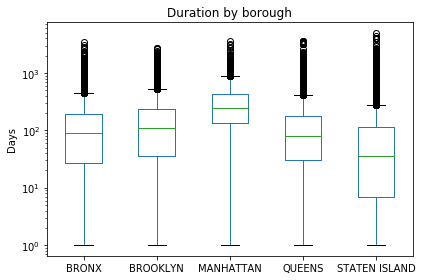

In [17]:
# Create a boxplot of Building Type Duration.
ax = data.boxplot(column=['Duration'], by=['Borough'])
plt.suptitle('')
ax.set_xlabel('')
ax.set_ylabel('Days')
ax.grid(False)
ax.set_title('Duration by borough')
ax.set_yscale('log')
plt.tight_layout()
pd.DataFrame(data.groupby('Borough')['Duration'].
             describe().loc[:,['mean','std','max']].round())

#### Duration of building permit issuance by Borough

* On average it takes the longest in Manhattan and shortest in Staten Island to obtain a building permit. 
* In Manhattan, it takes on average 11 months (333 days) to obtain a building permit, which is almost twice as long as in the rest of the 4 Boroughs. 
* However, there is also significant variance in Manhattan in the duration. 

In [18]:
# Group by data by boroughs and select the average duration based on the type of building.
# Group by data by boroughs and select the number of buildings based on the type of building.

bldg_type = pd.DataFrame(data.groupby(['Borough','Building Type']).count()['Approved'])
bldg_type_piv = (pd.pivot_table
                 (bldg_type, index='Borough', columns=['Building Type'], 
                  values='Approved').sort_values(by='1-2-3 FAMILY'))
group = pd.DataFrame(data.groupby(['Borough','Building Type'])['Duration'].mean())
group_piv = pd.pivot_table(index='Borough', columns='Building Type', 
                          values='Duration', data=group)

,mean,std,max
Building Type,,,
1-2-3 FAMILY,138.0,248.0,4959.0
OTHERS,241.0,274.0,3637.0


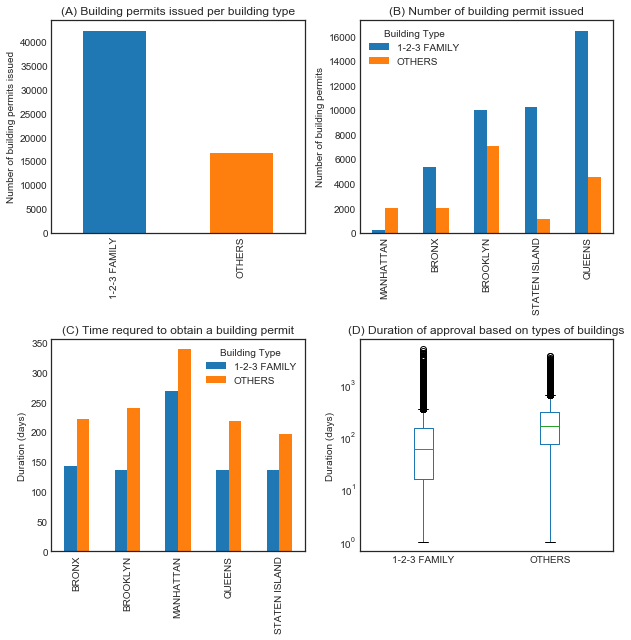

In [19]:
''' Create a subplot of 4 plots, indicating: 
    (A) number of building permits issued by type, 
    (B) number of building permits issued by type and borough, 
    (C) duration of approval of buildings by type and borough,
    (D) distribution of duration of approval of buildings by type.
'''

plt.style.use('seaborn-white')
fig = plt.figure(figsize = (9,9))

ax1 = fig.add_subplot(2,2,1)
data['Building Type'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Number of building permits issued')
ax1.set_title('(A) Building permits issued per building type')

ax2 = fig.add_subplot(2,2,2)
bldg_type_piv.plot(kind='bar', ax = ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Number of building permits')
ax2.set_title('(B) Number of building permit issued')
# ax2.legend('')

ax3 = fig.add_subplot(2,2,3)
group_piv[['1-2-3 FAMILY','OTHERS']].plot(kind='bar', ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('Duration (days)')
ax3.set_title('(C) Time requred to obtain a building permit')
# ax3.legend('')

ax4 = fig.add_subplot(2,2,4)
data.boxplot(column=['Duration'], by=['Building Type'], ax = ax4)
ax4.set_title('(D) Duration of approval based on types of buildings')
ax4.set_xlabel('')
ax4.set_ylabel('Duration (days)')
ax4.set_yscale('log')
ax4.grid(False)

plt.suptitle('')
plt.tight_layout()

pd.DataFrame(data.groupby('Building Type')['Duration'].
             describe().loc[:,['mean','std','max']].round())

#### Discussion: the type of buildings approved 

* The majority (>70%) of building permits were issued for 1,2 or 3 family buildings. This ratio varies significantly across the 5 Boroughs. 
* Manhattan is the only borough where the majority of the building permits where issued for the "Others" category, meaning anything other than 1,2 or 3 family houses. 
* The duration for obtaining a building permit is longer for "Others" category buildings than "1, 2 or 3 family" houses, by on average 79 days. 

In [20]:
# Pivot the data to get borough level duration for applicants that applied online 
# vs those who submitted in-person.

efile_boro = data.groupby(['Borough','Efiling Filed'])['Duration'].mean()
efile_pivot = pd.pivot_table(pd.DataFrame(efile_boro), 
                             index='Borough', columns='Efiling Filed')

,mean,std,max
Efiling Filed,,,
N,136.0,251.0,4959.0
Y,222.0,265.0,3585.0


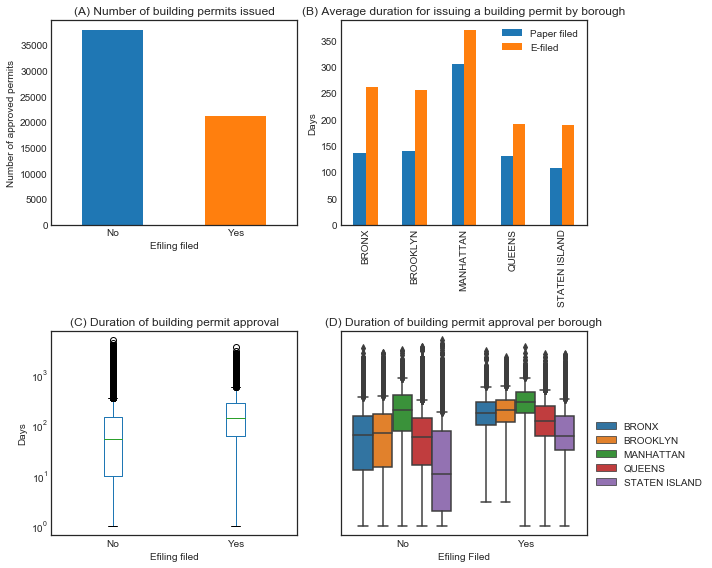

In [21]:
# subplot consisting of 4 plots.
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(10,8))

# bar plot of the number of building permits issued based on the efiling.
ax1 = fig.add_subplot(2,2,1)
data['Efiling Filed'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_title('(A) Number of building permits issued')
ax1.set_ylabel('Number of approved permits')
ax1.set_xlabel('Efiling filed')
ax1.set_xticklabels(['No','Yes'], rotation=360)

# bar plot of the duration of building permit approvals in each borough based on efiling.
ax2 = fig.add_subplot(2,2,2)
efile_pivot.plot(kind='bar', ax=ax2)
ax2.set_title('(B) Average duration for issuing a building permit by borough')
ax2.set_ylabel('Days')
ax2.set_xlabel('')
ax2.legend(['Paper filed','E-filed'])

# box plot of the duration of building permit approvals based on efiling.
ax3 = fig.add_subplot(2,2,3)
data.boxplot(column=['Duration'], by=['Efiling Filed'], ax=ax3)
ax3.set_title('(C) Duration of building permit approval')
ax3.set_ylabel('Days')
ax3.set_xlabel('Efiling filed')
ax3.set_xticklabels(['No','Yes'])
ax3.set_yscale('log')
plt.suptitle('')
ax3.grid(False)
plt.tight_layout()

# box plot of the duration of building permit approvals in each borough based on efiling.
ax4 = fig.add_subplot(2,2,4, sharey=ax3)
sns.boxplot(x='Efiling Filed', y='Duration',data=data, hue='Borough', ax=ax4, order=['N','Y'])
ax4.set_xticklabels(['No','Yes'])
ax4.set_title('(D) Duration of building permit approval per borough')
ax4.legend(bbox_to_anchor=(1, 0.6))
ax4.yaxis.set_visible(False)

plt.tight_layout()
pd.DataFrame(data.groupby(['Efiling Filed'])['Duration'].
             describe().loc[:,['mean','std','max']].round())

#### Discussion: E-filing for building permits
* The applicants that have NOT filed the application online seem to obtain the approval faster. We need to explore this further to understand the reason. 
* Looking into the data by borough we can see that this is true for all boroughs. However, the difference is very small in Manhattan.

,Applicant Professional Title
RA,44086
PE,14990


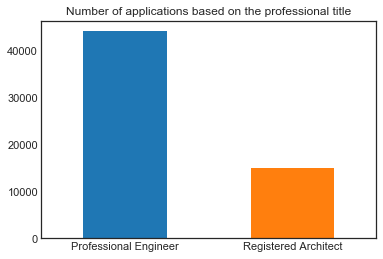

In [22]:
# bar chart of Professional Title.
ax = data['Applicant Professional Title'].value_counts().plot(kind='bar', fontsize=11)
ax.set_xticklabels(['Professional Engineer','Registered Architect'],rotation=360)
ax.set_title('Number of applications based on the professional title')
pd.DataFrame(data['Applicant Professional Title'].value_counts())

,mean,std,max
Applicant Professional Title,,,
PE,143.0,229.0,4959.0
RA,176.0,269.0,4411.0


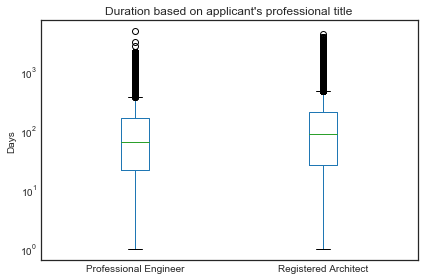

In [23]:
# Boxplot of Duration based on the applicants' professional title.
ax = data.boxplot(column=['Duration'], by=['Applicant Professional Title'])
ax.set_xticklabels(['Professional Engineer','Registered Architect'])
plt.suptitle('')
ax.set_title("Duration based on applicant's professional title")
ax.set_xlabel('')
ax.set_ylabel('Days')
ax.set_yscale('log')

ax.grid(False)
plt.tight_layout()
pd.DataFrame(data.groupby('Applicant Professional Title')['Duration'].
             describe().loc[:,['mean','std','max']].round())

,Professional Cert
N,38010
Y,21066


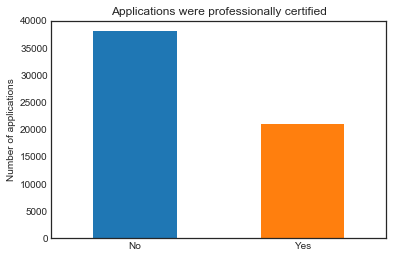

In [24]:
# Bar chart indicating whether or not the application was submitted as 
# professionally Certified by a Professional Engineer (PE) or Registered Architect (RA).
ax = data['Professional Cert'].value_counts().plot(kind='bar')
ax.set_xticklabels(['No','Yes'],rotation=360)
ax.set_title('Applications were professionally certified')
ax.set_ylabel('Number of applications')
pd.DataFrame(data['Professional Cert'].value_counts())

,mean,std,max
Professional Cert,,,
N,225.0,283.0,4959.0
Y,62.0,166.0,2589.0


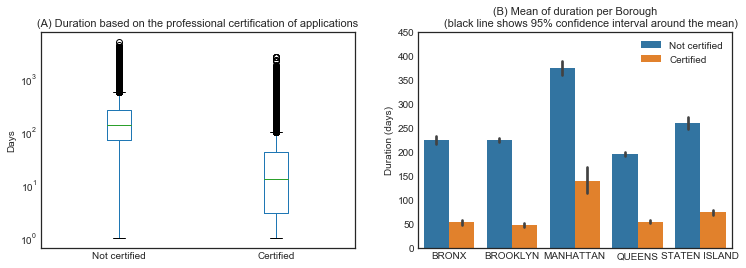

In [25]:
# boxplot of Duration based on wheather or not the applications were professionally certified.
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
data.boxplot(column=['Duration'], by=['Professional Cert'], ax=ax1)
ax1.set_xticklabels(['Not certified','Certified'])
plt.suptitle('')
ax1.set_title("(A) Duration based on the professional certification of applications", fontsize=11)
ax1.set_xlabel('')
ax1.set_ylabel('Days')
ax1.set_yscale('log')
ax1.grid(False)
ax1.yaxis.set_ticks_position('none')

# mean duration of approval in each borough based on the professional certification.
sns.barplot(x ='Borough', y ='Duration', hue='Professional Cert', data=data, ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Duration (days)')
ax2.set_ylim(0,450)
ax2.set_title('(B) Mean of duration per Borough' '\n \
          (black line shows 95% confidence interval around the mean)', fontsize=11)
legend = ax2.legend()
legend.get_texts()[0].set_text('Not certified')
legend.get_texts()[1].set_text('Certified')

pd.DataFrame(data.groupby('Professional Cert')['Duration'].
             describe().loc[:,['mean','std','max']].round())

#### Discussion: professionaly certified applications

From data we can observe that professionally certified applications are approved significantly faster than those that are not certified.  This makes sense because professionally certified application materials are less prone to errors and reduce the back and forth between the issuing agency and the applicant. 

,Total Est. Fee
mean,3950.0
std,84871.0
50%,614.0
max,16900000.0


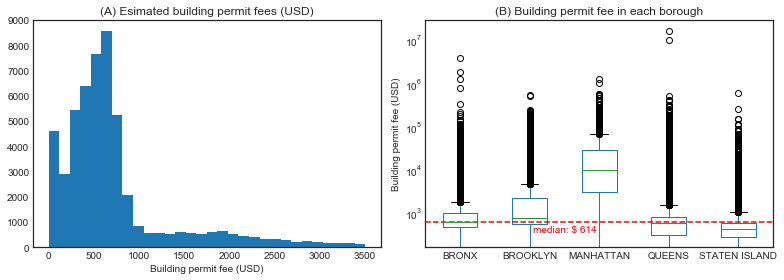

In [26]:
# histogram of building permit fee.
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(11,4))
data['Total Est. Fee'].hist(bins=30, range=(0,3500), ax=ax1)
ax1.set_title('(A) Esimated building permit fees (USD)')
ax1.set_xlabel('Building permit fee (USD)')
ax1.grid(False)

# boxplot of the fees by borough.
data.boxplot(column='Total Est. Fee', by='Borough', ax=ax2)
ax2.set_yscale('log')
ax2.grid(False)
ax2.set_title('(B) Building permit fee in each borough')
plt.suptitle('')
ax2.set_xlabel('')
ax2.set_ylabel('Building permit fee (USD)')
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
ax2.axhline(y=614, color='red', linestyle='--')
ax2.annotate('median: $ 614', xy=(3,620), xytext=(2.05,350), color='red')
plt.tight_layout() 
plt.tight_layout()
pd.DataFrame(data['Total Est. Fee'].describe().loc[['mean','std','50%','max']].round())

Text(2600,80000,'Correlation: 0.03')

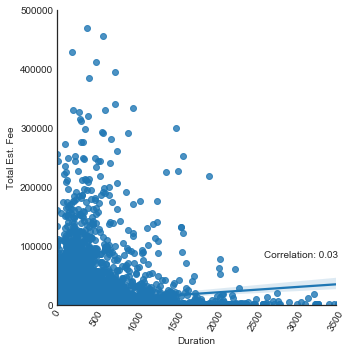

In [27]:
# scatterplot of building permit fee and duration and the correlation value. 
g = sns.lmplot(x='Duration',y='Total Est. Fee', data=data)
plt.xlim(0,3500)
plt.ylim(0,500000)
plt.xticks(rotation=60)
plt.tight_layout()
data['Total Est. Fee'].corr(data['Duration']).round(3)
ax = g.ax
ax.annotate('Correlation: ' + str(data['Total Est. Fee'].corr(data['Duration']).round(2)),
            xy=(2600,80000), xytext=(2600,80000))

#### Discussion: 
* The highest fees are in Manhattan and the lowest fees are in Staten Island. 
* Building permit fees range from USD 0 to more than several million dollars. 
* However, most of the building permit applicants pay between USD 0 and USD 3,500 with a median fee of USD 614.  
* There seems to be no correlation between the estimated fee and the duration of approval. However, there are significant outliers in both variables that might affect the correlation value. 

,Proposed Zoning Sqft
mean,14164.0
std,109754.0
50%,0.0
max,6501958.0


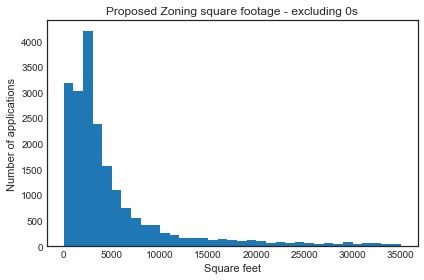

In [28]:
# Histogram of Proposed Zoning square footage. 
fig, ax = plt.subplots()
ax = data['Proposed Zoning Sqft'].hist(bins=35, range=(1,35000))
ax.set_title('Proposed Zoning square footage - excluding 0s')
ax.set_xlabel('Square feet',fontsize=11)
ax.set_ylabel('Number of applications',fontsize=11)
ax.grid(False)
plt.tight_layout()
pd.DataFrame(data['Proposed Zoning Sqft'].describe().round(0)).loc[['mean','std','50%','max']]

Text(4.5e+06,2500,'correlation: 0.12')

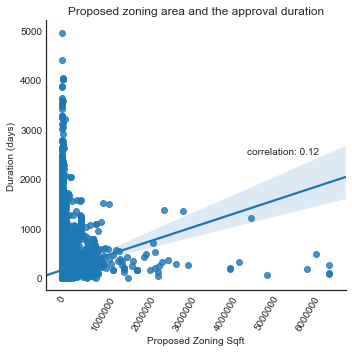

In [29]:
# scatterplot of proposed zoning square feet vs Duration.
g = sns.lmplot(x='Proposed Zoning Sqft', y='Duration', data=data)
# plt.xscale('log')
# plt.xlim(1,500000)
plt.xticks(rotation=60)
plt.title('Proposed zoning area and the approval duration')
plt.ylabel('Duration (days)')
plt.tight_layout()
cor_zon_dur = data['Proposed Zoning Sqft'].corr(data['Duration']).round(2)
g.ax.annotate('correlation: '+ str(cor_zon_dur), xy=(4500000,2500), xytext=(4500000,2500))

#### Discussion: proposed zoning area (sqft)
* Most of the entries for the proposed zonig area (sqft) is null. This is probably due to the fact that submitted applications left this information blank. 
* Overall, the data is ditributed between 0 and 3000 square feet. If we exclude 0 (blank) entries, most of the new building applications indicate a ground area (zoning square feet) of between 10 to 500 square feet. 
* There seems to be some positive correlation between the zoning square footage and the duration of approval. However, there are significant outliers in both variables and the correlation might change if we take out some of the outliers. 

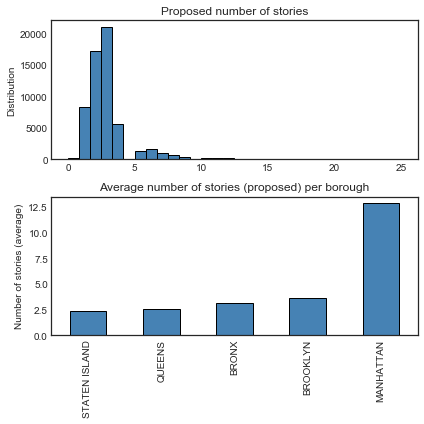

In [30]:
# Histogram of Proposed No. Of Stories. 
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,6))
data['Proposed No. Of Stories'].hist(bins=30, range=(0,25),
                                     ax=ax1, color='steelblue', edgecolor='k')
ax1.set_title('Proposed number of stories')
ax1.set_xlabel('')
ax1.set_ylabel('Distribution')
ax1.grid(False)

# bar graph of the average number of stories by borough. 
floor = data.groupby('Borough')['Proposed No. Of Stories'].mean().sort_values()
floor.plot(kind='bar', color='steelblue', edgecolor='k', ax=ax2)
ax2.set_title('Average number of stories (proposed) per borough')
ax2.set_xlabel('')
ax2.set_ylabel('Number of stories (average)')
ax2.grid(False)
plt.tight_layout()
plt.tight_layout()

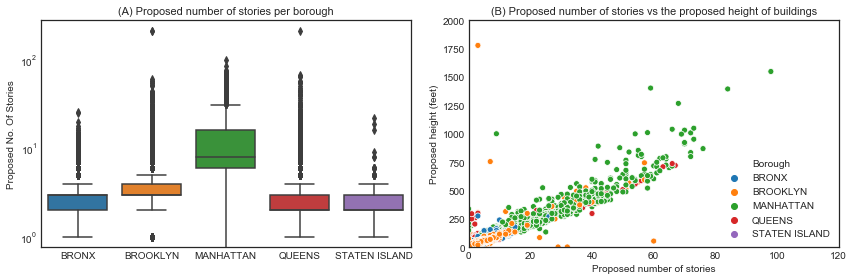

In [63]:
# Boxplot of Proposed No. Of Stories in each borough.
f, axes = plt.subplots(1, 2, figsize=(12, 4)) #sharey=True)
sns.boxplot(data=data,x='Borough', y='Proposed No. Of Stories', ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('')
axes[0].set_title('(A) Proposed number of stories per borough', fontsize=11)
axes[1].set_ylabel('Proposed number of stories')
sns.scatterplot(data=data,x='Proposed No. Of Stories', y='Proposed Height', hue='Borough',
                ax = axes[1])
axes[1].set(xlim=(0,120), ylim=(0,2000))
axes[1].set_title('(B) Proposed number of stories vs the proposed height of buildings',
                  fontsize=11)
axes[1].set_xlabel('Proposed number of stories')
axes[1].set_ylabel('Proposed height (feet)')
plt.tight_layout()
pd.DataFrame((data['Proposed No. Of Stories']).
             describe()).loc[['mean','std','50%','max']].round(1)

plt.savefig('stories_per_boro.png')

Text(0.5,6.8,'Proposed No. of Stories')

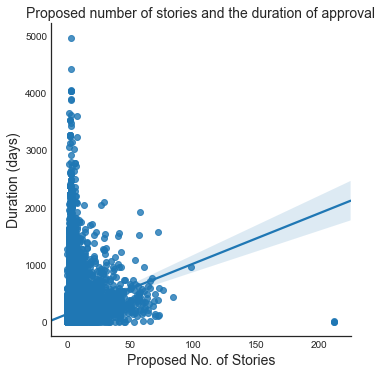

In [69]:
# scatterplot of proposed number of stories and duration.

sns.lmplot(x='Proposed No. Of Stories', y='Duration', 
           data=data[data['Duration'] > 0])
plt.title('Proposed number of stories and the duration of approval', fontsize=14)
plt.ylabel('Duration (days)', fontsize=14)
plt.xlabel('Proposed No. of Stories', fontsize=14)

#### Discussion: proposed number of stories and height 
* Overall, the vast majority of proposed buildings are between 1-5 floors. 
* The average number of stories is around 12.5 in Manhattan and between 2-3 in the rest of the 4 boroughs.
* The highest buildings are proposed in Manhattan. The shortest are in Staten Island and the Bronx.
* the relationship between the proposed height and the number of stories is quite strong and linear. However, from the same figure, we can see that there are quite a few anomalies, such as buildings as high as 1750 feet but with less than 5 floors. Or buildings with more than 60 stories but with height less than 10 feet. This scatter plot helps us to evaluate the quality of data and possibly filter out values that do not make sense. 


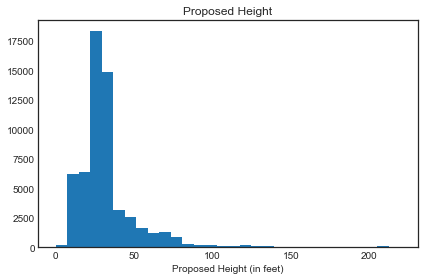

In [33]:
# Histogram of Proposed Height. 
ax = data['Proposed Height'].hist(bins=30, range=(0,220))
ax.set_title('Proposed Height')
ax.set_xlabel('Proposed Height (in feet)')
ax.grid(False)
pd.DataFrame((data['Proposed Height']).describe()).round(1)
plt.tight_layout()

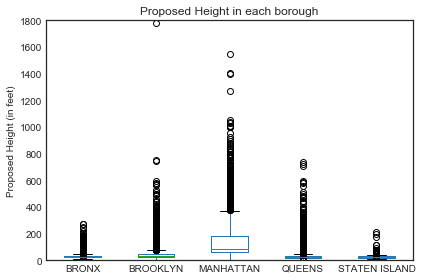

In [34]:
# Boxplot of Proposed Height in each borough. 
ax = data.boxplot(column='Proposed Height', by='Borough')
ax.set(ylim=(0,1800))
ax.set_xlabel('')
ax.set_ylabel('Proposed Height (in feet)')
ax.set_title('Proposed Height in each borough')
plt.suptitle('')
ax.grid(False)
plt.tight_layout()

(0, 5100)

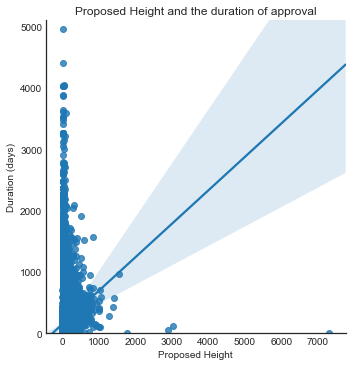

In [35]:
# scatterplot of proposed height and duration.

sns.lmplot(x='Proposed Height', y='Duration', data=data)
plt.title('Proposed Height and the duration of approval')
plt.ylabel('Duration (days)')
plt.ylim(0,5100)

,Proposed Dwelling Units
count,50387.0
mean,10.1
std,103.1
min,0.0
25%,1.0
50%,2.0
75%,3.0
max,21240.0


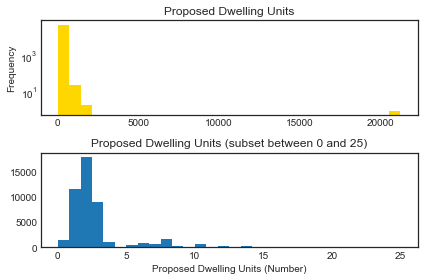

In [36]:
# Histogram of Proposed Height. 
fig,ax = plt.subplots(2,1, sharey=True)
plt.subplot(2,1,1)
ax = data['Proposed Dwelling Units'].plot(kind='hist', bins=30, color='gold', logy=True)
ax.set_title('Proposed Dwelling Units')
ax.grid(False)

plt.subplot(2,1,2)
ax1 = data['Proposed Dwelling Units'].hist(bins=30, range=(0,25))
ax1.set_title('Proposed Dwelling Units (subset between 0 and 25)')
ax1.set_xlabel('Proposed Dwelling Units (Number)')
ax1.grid(False)

plt.tight_layout()
pd.DataFrame((data['Proposed Dwelling Units']).describe()).round(1)

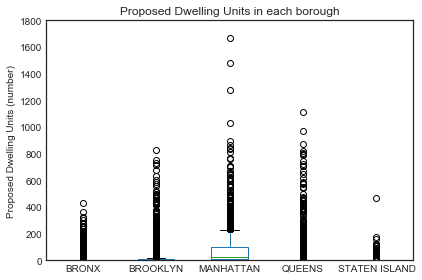

In [37]:
# Boxplot of Proposed Dwelling Units in each borough. 
ax = data.boxplot(column='Proposed Dwelling Units', by='Borough')

# ax = sns.boxplot(data=data,x='Borough', y='Proposed Dwelling Units')
ax.set(ylim=(0,1800))
ax.set_xlabel('')
ax.set_ylabel('Proposed Dwelling Units (number)')
ax.set_title('Proposed Dwelling Units in each borough')
plt.suptitle('')
ax.grid(False)
plt.tight_layout()

(0, 2000)

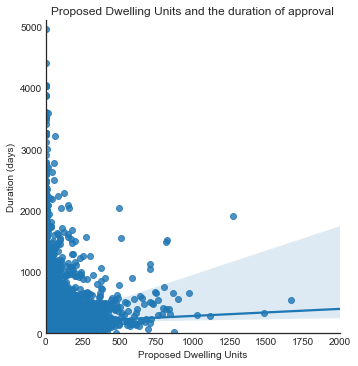

In [38]:
# scatterplot of proposed dwelling units and duration.

sns.lmplot(x='Proposed Dwelling Units', y='Duration', data=data)
plt.title('Proposed Dwelling Units and the duration of approval')
plt.ylabel('Duration (days)')
plt.ylim(0,5100)
plt.xlim(0,2000)

In [39]:
data.head(2)

,Borough,Building Type,Efiling Filed,Applicant Professional Title,Professional Cert,Fully Paid,Approved,Total Est. Fee,Proposed Zoning Sqft,Proposed No. Of Stories,...,Proposed Occupancy,Zoning Dist1,Zoning Dist2,Zoning Dist3,Special District 1,Special District 2,Non-Profit,Total_Construction_Floor_Area,Signoff_Date,Duration
0,QUEENS,1-2-3 FAMILY,Y,RA,N,2018-11-02,2019-04-09,243.00,2700,2,...,R-3,R3A,NaN,NaN,NaN,NaN,N,4050,NaT,158.0
1,BROOKLYN,OTHERS,Y,RA,N,2012-03-27,2013-03-14,52167.26,161567,14,...,R-1,M1-2/R6,NaN,NaN,MX-8,GW,N,198951,NaT,352.0


### Categorical variables that have multiple categories 

#### How to visualize the categorigal variables that have too many categories for a bar chart or box plot?

Zoning, Special Districts and Proposed Occupany variables have multiple categoris each, ranging from 8 (Special District 2) to 43 (Proposed Occupancy) to 164 (Zoning Dist1) and anything in between. 

In [40]:
data['Proposed Occupancy'].unique()

array(['R-3', 'R-1', 'U', 'R-2', 'E', 'M', 'S-2', 'J-3', 'B', 'S-1',
       'B-2', 'F-1', 'J-2', 'F-1B', 'A-3', 'J-0', 'A-4', 'PUB', 'C',
       'B-1', 'G', 'RES', 'J-1', nan, 'A-5', 'I-1', 'A-2', 'F-2', 'F-3',
       'COM', 'D-1', 'D-2', 'H-2', 'K', 'F-4', 'I-2', 'I-4', 'F-1A', 'A',
       'H-5', 'A-1', 'H-1', 'H-3'], dtype=object)

Text(0,0.5,'Days')

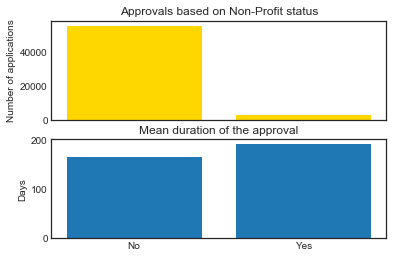

In [41]:
#bar chart of the Non-profit category.

fig, (ax1,ax2) = plt.subplots(2, sharex=True)

ngo=(data.groupby('Non-Profit')[['Approved','Duration']].
agg({'Approved':'count', 'Duration':'mean'}))

ax1.bar(ngo.index, ngo['Approved'], color='gold')
ax1.set_title('Approvals based on Non-Profit status')
ax1.set_ylabel('Number of applications')

ax2.bar(ngo.index, ngo['Duration'])
ax2.set_title('Mean duration of the approval')
ax2.set_xticklabels(['No','Yes'], rotation=360)
ax2.set_ylabel('Days')

# clarify the title and other a box plot.


,Total_Construction_Floor_Area
count,59076.0
mean,13557.1
std,70007.6
min,0.0
25%,2319.0
50%,3453.0
75%,5481.2
max,7142400.0


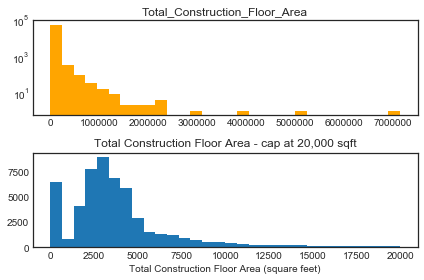

In [42]:
# Histogram of Total Construction Floor Area. 

fig,ax = plt.subplots(2,1)

plt.subplot(2,1,1)
ax = data['Total_Construction_Floor_Area'].hist(bins=30, color='orange')
ax.set_title('Total_Construction_Floor_Area')
ax.set_yscale('log')
# ax.set_xlabel('Total_Construction_Floor_Area (square feet)')
ax.grid(False)

plt.subplot(2,1,2)
ax1 = data['Total_Construction_Floor_Area'].hist(bins=30,  range=(0,20000))
ax1.set_title('Total Construction Floor Area - cap at 20,000 sqft')
ax1.set_xlabel('Total Construction Floor Area (square feet)')
ax1.grid(False)

plt.tight_layout()
pd.DataFrame((data['Total_Construction_Floor_Area']).describe()).round(1)


(0, 2000000)

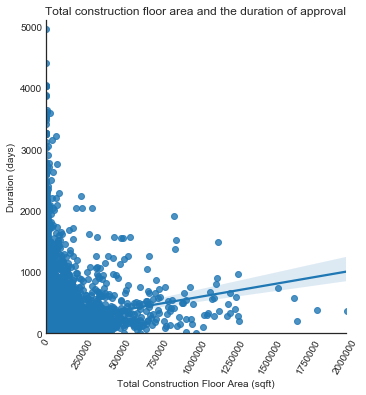

In [43]:
# scatterplot of Total construction floor area and duration.

sns.lmplot(x='Total_Construction_Floor_Area', y='Duration', data=data)
plt.title('Total construction floor area and the duration of approval')
plt.ylabel('Duration (days)')
plt.xlabel('Total Construction Floor Area (sqft)')
plt.ylim(0,5100)
plt.xticks(rotation=60)
plt.xlim(0,2000000)

### Further analysis of the dependent variable and explanatory variables.

Heatmap of all variables and correlations.

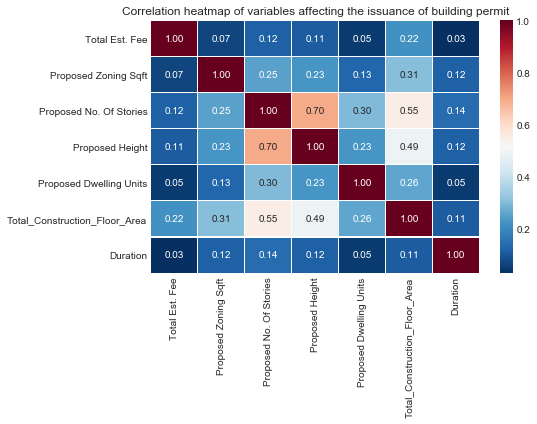

In [44]:
import seaborn as sns
corr = data.corr()
plt.style.use('seaborn-white')
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(round(corr,2), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap="RdBu_r", annot=True, fmt='.2f', linewidths=.05, ax=ax)
ax.set_title('Correlation heatmap of variables affecting the issuance of building permit')

plt.tight_layout()

,Duration
count,59076.000000
mean,167.168969
std,259.648127
min,1.000000
25%,25.000000
50%,83.000000
75%,201.000000
max,4959.000000


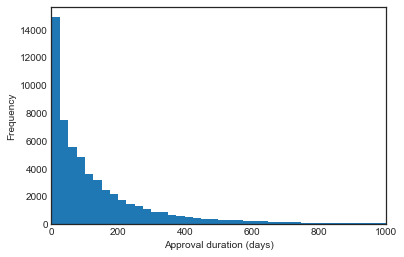

In [45]:
# Create a histogram of duration and include a statistical analysis.
data['Duration'].plot(kind='hist', bins = 200)
plt.xlim(0,1000)
plt.xlabel('Approval duration (days)')
pd.DataFrame(data['Duration'].describe())

Text(0.5,1,'Mean and median duration by borough')

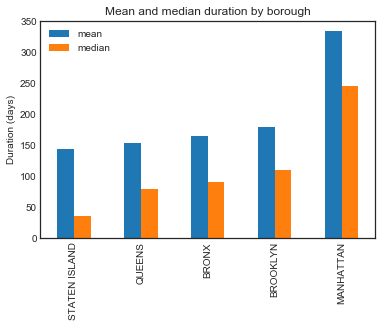

In [46]:
ax = (data.groupby('Borough')['Duration'].agg(['mean','median'])
      .sort_values(by='mean').plot(kind='bar'))
ax.set_xlabel('')
ax.set_ylabel('Duration (days)')
ax.set_title('Mean and median duration by borough')

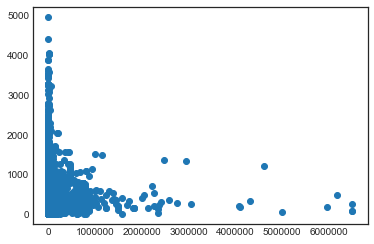

In [47]:
# scatter plot of Proposed Zoning Sqft (x) Duration (y) 
plt.scatter(x=data['Proposed Zoning Sqft'], y=data['Duration'])

### Selecting outliers

Selecting outliers based on the Duration variable. Applying a filter to
select values that are +- 3 standard deviation in this variable. Total number of outliers is
1242 data points, which is 2.1% of the total data.

In [48]:
from scipy.stats import zscore

In [49]:
data['Z_score'] = zscore(data['Duration'])

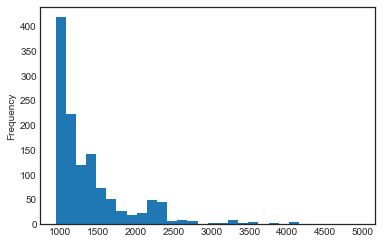

In [50]:
data[data['Z_score'] > 3]['Duration'].plot(kind='hist', bins=30)
# x axis labels add

### Aggregate proposed occupancy, zoning & special district categories into larger groups

* Zoning Districts 1,2 and 3 are mainly in Queens

In [51]:
# create a list with values to replace with 'OTHER'
other_occupancy = []
for k,v in data['Proposed Occupancy'].value_counts().items():
    if v < 500:
        other_occupancy.append(k)

In [52]:
# replace values in the proposed occupancy that are less than 500 with 'other'
data['Proposed Occupancy'].replace(other_occupancy,'Other', inplace=True)

In [53]:
# create a list of items that are less than 50 data points 
other1 = []
for k, v in data['Zoning Dist1'].value_counts().items():
    if v < 200:
        other1.append(k)

In [54]:
# replace values in the proposed occupancy that are less than 500 with 'other'
data['Zoning Dist1'].replace(other1,'Other', inplace=True)

Text(0,0.5,'Number of applications')

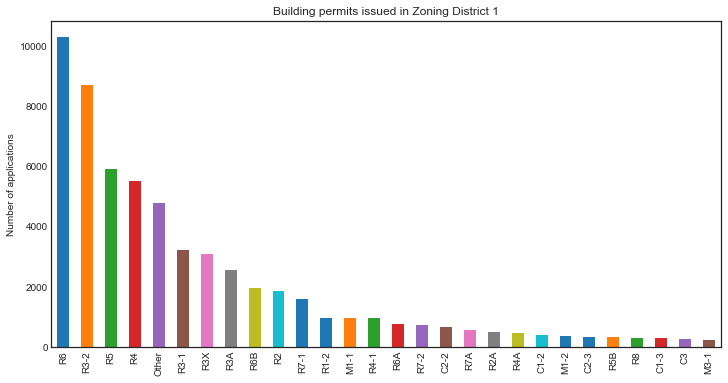

In [55]:
# bar plot of the new zoning district 1 values
ax = data['Zoning Dist1'].value_counts().plot(kind='bar',figsize=(12,6))
ax.set_title('Building permits issued in Zoning District 1')
ax.set_ylabel('Number of applications')

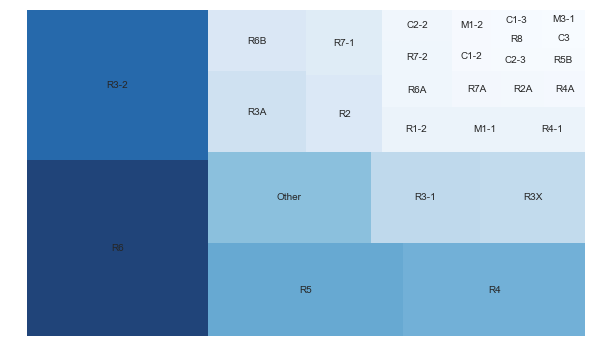

In [56]:
import squarify

# colors = plt.cm.Blues()

# colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
norm = mpl.colors.Normalize(vmin=min(data['Zoning Dist1'].value_counts()),
                            vmax=max(data['Zoning Dist1'].value_counts()))
colors = [mpl.cm.Blues(norm(value)) for value in data['Zoning Dist1'].value_counts()]


ax = squarify.plot(sizes=data['Zoning Dist1'].value_counts().values,
     label=data['Zoning Dist1'].value_counts().index, alpha=.9, color=colors)
ax.figure.set_size_inches(10,6)
plt.axis('off');


In [57]:
other2 = []

for k,v in data['Zoning Dist2'].value_counts().items():
    if v < 30:
        other2.append(k)

In [58]:
data['Zoning Dist2'] = data['Zoning Dist2'].replace(other2, 'Other')

#### Zoning Dist2 variable has 54356 NaN values out of total 59076 (~ 8% of values are not NaN) 
##### Aggregated all categories that have less than 30 entries into "Other" category, which has now 559 entries.

In [59]:
other_Dist1 = []
for k,v in data['Special District 1'].value_counts().items():
    if v < 30:
        other_Dist1.append(k)

In [60]:
data['Special District 1'] = data['Special District 1'].replace(other_Dist1, 'Other')

In [61]:
data['Special District 1'].value_counts()

SRD      2138
SR       1076
OP        465
Other     423
HS        229
LIC       210
MX-8      178
NA-1      157
CD         88
MID        80
H          73
DB         73
BR         72
DJ         64
SB         44
CL         43
WCH        37
LM         36
HY         32
Name: Special District 1, dtype: int64

### How to deal with these 4 zoning variables that have very few valid cells 
#### (especially Zoning Dist3 and Special District 2)

Zoning Dist2 -- 4720 non-null object

Zoning Dist3 -- 202 non-null object

Special District 1 -- 5518 non-null object

Special District 2 -- 600 non-null object
